In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout

import matplotlib.pyplot as plt
import re
import seaborn as sns

In [2]:
df = pd.read_csv('C:/Users/outlul/Desktop/Πτυχιακη/Code/Datasets/WELFake_Cleaned.csv')
df.text = df.text.astype(str)

In [3]:
X = df['text']
y = df['label']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)

In [5]:
# Tokenizing text
vocab = 20000
tokenizer = Tokenizer(num_words= vocab)
tokenizer.fit_on_texts(X_train)

# Text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Padding
X_train_padded = pad_sequences(X_train_sequences, maxlen=256)
X_test_padded = pad_sequences(X_test_sequences, maxlen=256)

In [6]:
#WORD EMBEDDINGS FROM GLOVE PRE-TRAINED SET

embedding_path = "D:/Glove_DeepLearning/glove.6B.300d.txt"
embedding_dim = 300
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embedding_index = dict(get_coefs(*o.split(" ")) for o in open(embedding_path, encoding='utf-8', errors='ignore'))
all_embs = np.stack(embedding_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()

word_index = tokenizer.word_index
num_words = len(tokenizer.word_index)
nb_words = min(num_words, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words + 1, embedding_dim))
for word, i in word_index.items():
    if i >= num_words: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector


F:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3400: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


In [9]:
model = Sequential()
model.add(Embedding(331135, 300, weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))


earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Compile
model.compile(optimizer='Nadam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         99340500  
                                                                 
 bidirectional (Bidirectiona  (None, 200)              320800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 99,661,501
Trainable params: 99,661,501
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
# Train the model
history = model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=6, batch_size=124, callbacks=[earlystop])

# Evaluate the model
train_loss, train_accuracy = model.evaluate(X_train_padded, y_train)
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)

print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/6
461/461 [==============================] - 319s 693ms/step - loss: 0.2435 - accuracy: 0.9009 - val_loss: 0.1624 - val_accuracy: 0.9331
Epoch 2/6
461/461 [==============================] - 332s 720ms/step - loss: 0.1103 - accuracy: 0.9600 - val_loss: 0.1098 - val_accuracy: 0.9592
Epoch 3/6
461/461 [==============================] - 326s 708ms/step - loss: 0.0540 - accuracy: 0.9823 - val_loss: 0.1122 - val_accuracy: 0.9637
Epoch 4/6
446/446 [==============================] - 24s 53ms/step - loss: 0.1098 - accuracy: 0.9592
Train Loss: 0.057418353855609894
Train Accuracy: 0.9813945293426514
Test Loss: 0.10984624922275543
Test Accuracy: 0.9592179656028748


[0.2435310035943985, 0.11028943210840225, 0.05400886386632919, 0.023149434477090836]
[0.16236412525177002, 0.10984620451927185, 0.11216998845338821, 0.20710396766662598]
[0.900858461856842, 0.9599859714508057, 0.9823230504989624, 0.9931674599647522]
[0.9330810904502869, 0.9592179656028748, 0.9637026190757751, 0.9398780465126038]


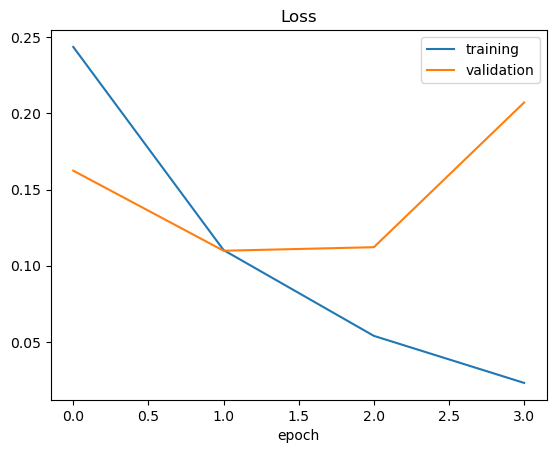

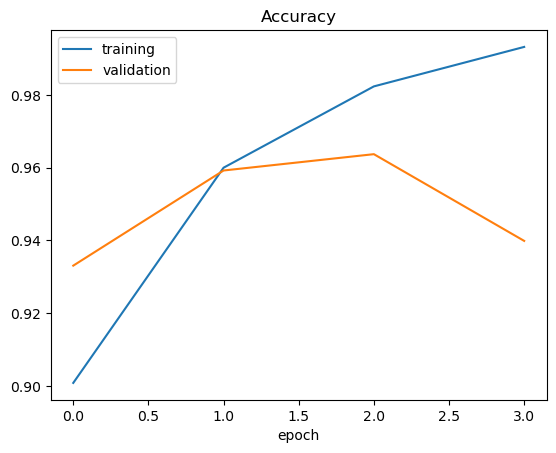

In [12]:
print(history.history['loss'])
print(history.history['val_loss'])
print(history.history['accuracy'])
print(history.history['val_accuracy'])

plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')


plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

plt.show()

In [13]:
prd_df = pd.read_csv('C:/Users/outlul/Desktop/Πτυχιακη/Code/Datasets/HugeDatasetPredictSample.csv')

In [14]:
val_text = prd_df['text']
val_label = prd_df['label']

In [15]:
val_text_sequences = tokenizer.texts_to_sequences(val_text)

val_text_padded = pad_sequences(val_text_sequences, maxlen=256)

In [16]:
test2_loss, test2_accuracy = model.evaluate(val_text_padded, val_label)

313/313 [==============================] - 16s 52ms/step - loss: 0.9481 - accuracy: 0.7119


In [17]:
pred = model.predict(val_text_padded)

313/313 [==============================] - 16s 47ms/step


In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report, ConfusionMatrixDisplay

In [19]:
binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

Accuracy on testing set: 0.7119
Precision on testing set: 0.9215311004784689
Recall on testing set: 0.5229905865314989


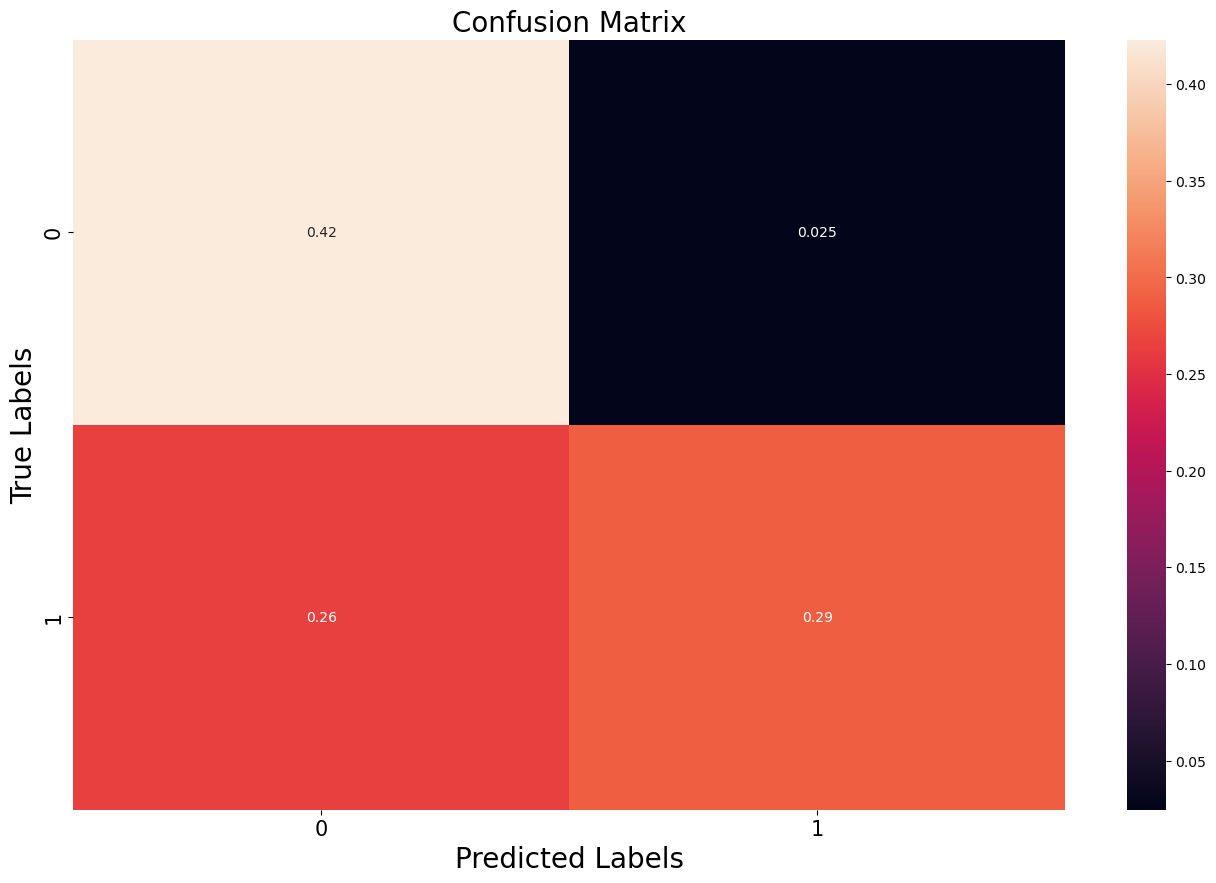

In [20]:
matrix = confusion_matrix(binary_predictions, val_label, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

print('Accuracy on testing set:', accuracy_score(binary_predictions, val_label))
print('Precision on testing set:', precision_score(binary_predictions, val_label))
print('Recall on testing set:', recall_score(binary_predictions, val_label))

In [21]:
print("Classification Report on Fake News Corpus Validation set\n")
print(classification_report(binary_predictions, val_label))

Classification Report on Fake News Corpus Validation set

              precision    recall  f1-score   support

           0       0.62      0.95      0.75      4476
           1       0.92      0.52      0.67      5524

    accuracy                           0.71     10000
   macro avg       0.77      0.73      0.71     10000
weighted avg       0.78      0.71      0.70     10000



446/446 [==============================] - 23s 51ms/step
Accuracy on testing set: 0.9592179945343704
Precision on testing set: 0.9658436213991769
Recall on testing set: 0.9548413344182262
Classification Report on Training set

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      6897
           1       0.97      0.95      0.96      7374

    accuracy                           0.96     14271
   macro avg       0.96      0.96      0.96     14271
weighted avg       0.96      0.96      0.96     14271



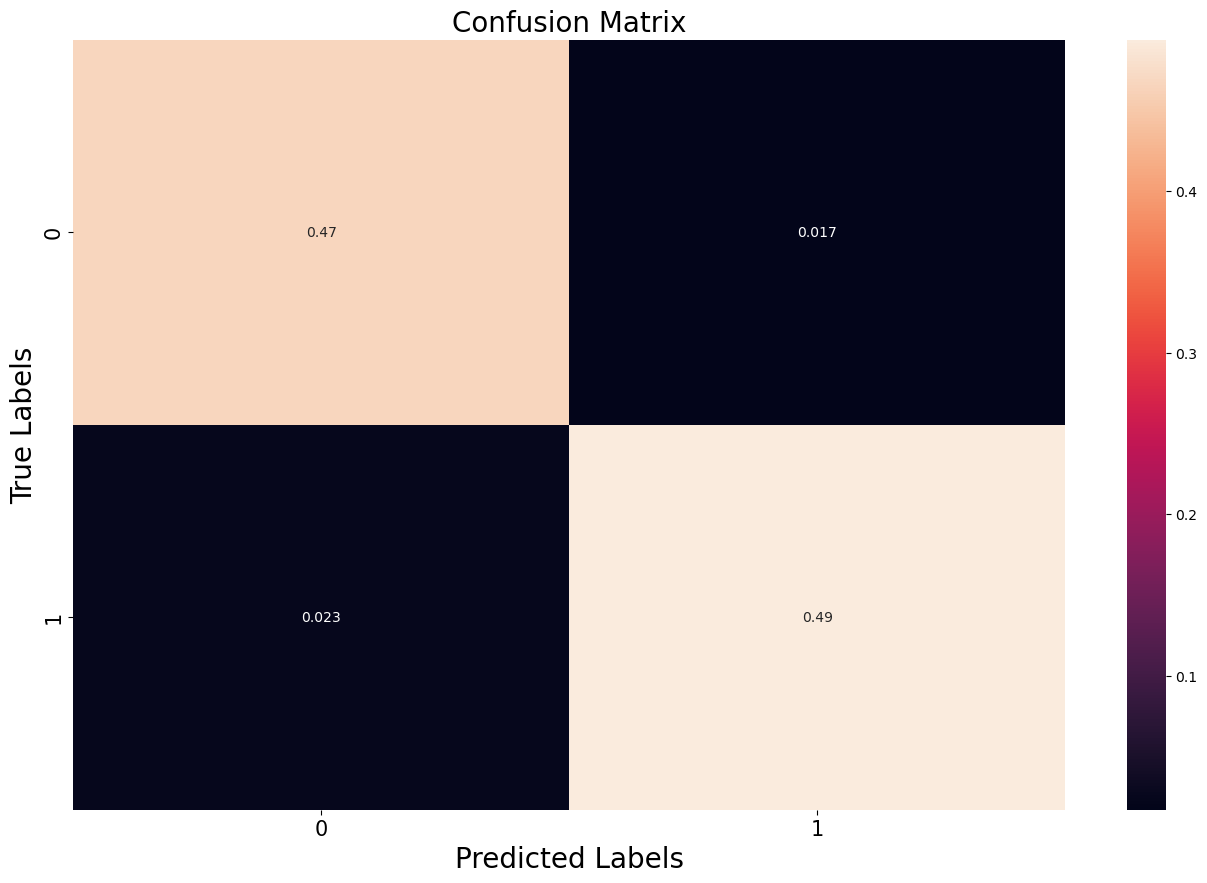

In [22]:
pred = model.predict(X_test_padded)

binary_predictions_Train = []

for i in pred:
    if i >= 0.5:
        binary_predictions_Train.append(1)
    else:
        binary_predictions_Train.append(0) 
        
matrix = confusion_matrix(binary_predictions_Train, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

print('Accuracy on testing set:', accuracy_score(binary_predictions_Train, y_test))
print('Precision on testing set:', precision_score(binary_predictions_Train, y_test))
print('Recall on testing set:', recall_score(binary_predictions_Train, y_test))

print("Classification Report on Training set\n")
print(classification_report(binary_predictions_Train, y_test))

250/250 [==============================] - 13s 52ms/step
Accuracy on testing set: 0.4655540218346091
Precision on testing set: 0.8345671981776766
Recall on testing set: 0.4434861552428507
Classification Report on LIAR set

              precision    recall  f1-score   support

           0       0.17      0.57      0.27      1360
           1       0.83      0.44      0.58      6609

    accuracy                           0.47      7969
   macro avg       0.50      0.51      0.42      7969
weighted avg       0.72      0.47      0.53      7969



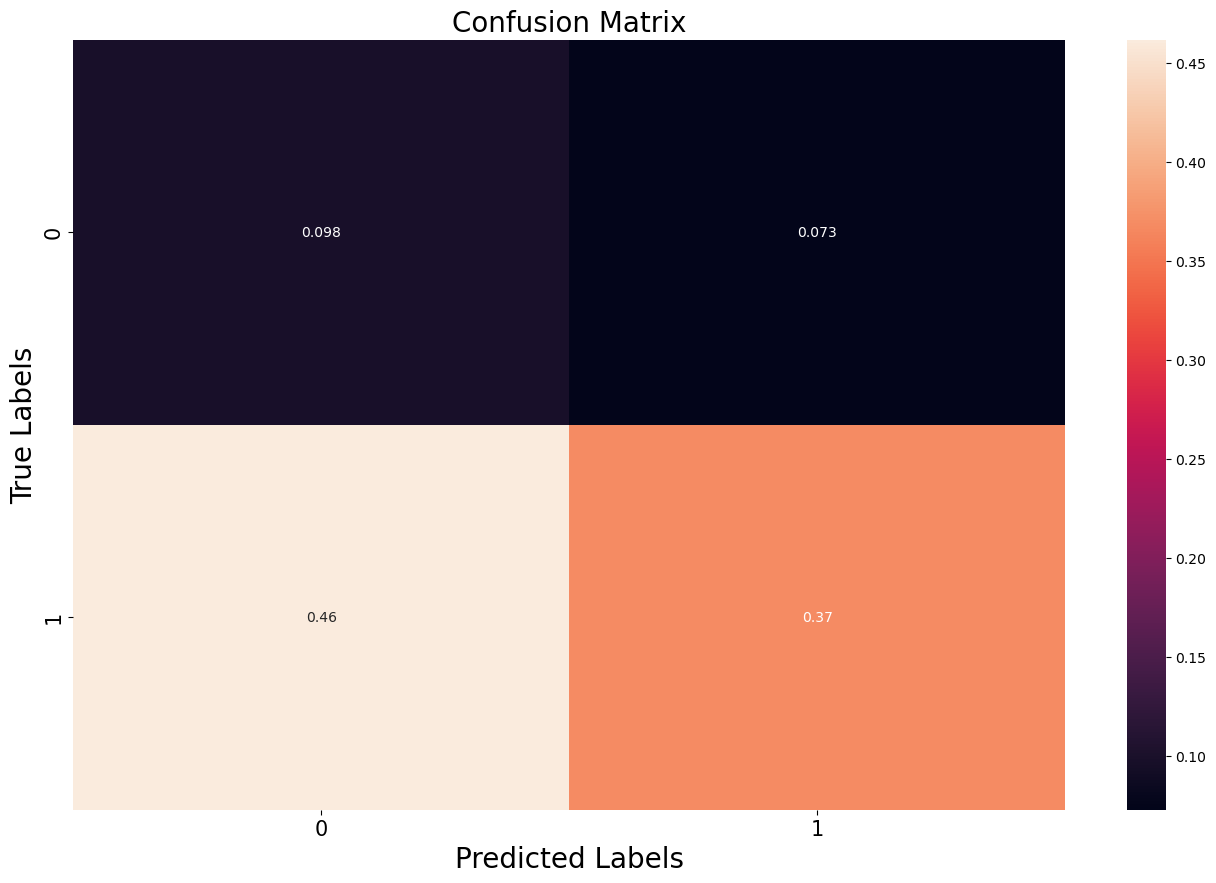

In [23]:
liar_df = pd.read_csv('C:/Users/outlul/Desktop/Πτυχιακη/Code/Datasets/Liar_preprocessed_nolemma.csv')

liar_text = liar_df['text']
liar_label = liar_df['Label']

liar_text_sequences = tokenizer.texts_to_sequences(liar_text)

liar_text_padded = pad_sequences(liar_text_sequences, maxlen=256)

pred_liar = model.predict(liar_text_padded)

binary_predictions_liar = []

for i in pred_liar:
    if i >= 0.5:
        binary_predictions_liar.append(1)
    else:
        binary_predictions_liar.append(0) 
        
matrix = confusion_matrix(binary_predictions_liar, liar_label, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

print('Accuracy on testing set:', accuracy_score(binary_predictions_liar, liar_label))
print('Precision on testing set:', precision_score(binary_predictions_liar, liar_label))
print('Recall on testing set:', recall_score(binary_predictions_liar, liar_label))

print("Classification Report on LIAR set\n")
print(classification_report(binary_predictions_liar, liar_label))

In [24]:
#import joblib

#filename = "Welfake_NoLemma_model.joblib"
#joblib.dump(model, filename)